In [12]:
# import tensorflow as tf
from datasets import load_dataset
import numpy as np
import re
import pandas as pd

ds = load_dataset("dair-ai/emotion", 'split')         
df_whole = pd.DataFrame(ds['test'])



In [ ]:
url   = re.compile(r'https?://\S+')
mention  = re.compile(r'@\w+')
hashtags = re.compile(r'#\w+')

tokens_with_url  = sum(bool(url.search(t)) for t in df_whole)
tokens_with_tag  = sum(bool(mention.search(t)) for t in df_whole)
tokens_with_hastags = sum(bool(hashtags.search(t)) for t in df_whole)
print(tokens_with_url, "tweets contain URLs;",
      tokens_with_tag, "contain @mentions",
      tokens_with_hastags, "contain Hashtags")


0 tweets contain URLs; 0 contain @mentions 0 contain Hashtags


In [17]:
df_whole

,text,label
0,im feeling rather rotten so im not very ambiti...,0
1,im updating my blog because i feel shitty,0
2,i never make her separate from me because i do...,0
3,i left with my bouquet of red and yellow tulip...,1
4,i was feeling a little vain when i did this one,0
...,...,...
1995,i just keep feeling like someone is being unki...,3
1996,im feeling a little cranky negative after this...,3
1997,i feel that i am useful to my people and that ...,1
1998,im feeling more comfortable with derby i feel ...,1


There are 6 emotions:
0- Sadness
1- Joy
2- Love
3- Anger
4- Fear
5- Surprise

In [6]:
train_tweets = ds["train"]["text"]
val_tweets   = ds["validation"]["text"]
test_tweets  = ds["test"]["text"]

train_emotions = ds["train"]["label"]
val_emotions   = ds["validation"]["label"]
test_emotions  = ds["test"]["label"]

num_classes = 6

In [16]:
test_emotions.features

ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'])

In [9]:
len(test_tweets)

2000

In [14]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_VOCAB = 20000
MAX_LEN   = 50
tf.random.set_seed(42)
np.random.seed(42)

tok = Tokenizer(num_words=MAX_VOCAB, oov_token="<OOV>")
tok.fit_on_texts(train_tweets)

def encode(texts):
    seqs = tok.texts_to_sequences(texts)
    return pad_sequences(seqs, maxlen=MAX_LEN, padding="post", truncating="post")

X_train = encode(train_tweets)
X_val   = encode(val_tweets)
X_test  = encode(test_tweets)

y_train = tf.keras.utils.to_categorical(train_emotions, num_classes)
y_val   = tf.keras.utils.to_categorical(val_emotions,   num_classes)
y_test  = tf.keras.utils.to_categorical(test_emotions,  num_classes)




In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv1D, Dropout, LSTM, MaxPooling1D, Embedding, Input

VOCAB_SIZE = 20000
EMBED_SIZE = 128
MAX_LEN    = 50          

model = Sequential([
    Input(shape=(MAX_LEN,)),    
    Embedding(VOCAB_SIZE, EMBED_SIZE),
    Conv1D(128, 4, padding='same', activation='relu'),
    MaxPooling1D(2),
    Conv1D(32, 4, padding='same', activation='relu'),
    MaxPooling1D(2),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(6, activation='softmax')                 
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 50, 128)        │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 50, 128)        │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 25, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 25, 32)         │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 12, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,742,182 (10.46 MB)

 Trainable params: 2,742,182 (10.46 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=5, batch_size=64,
     verbose=1
)

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print(f"\nTest loss: {test_loss:.4f} | Test accuracy: {test_acc:.4%}")

Epoch 1/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - accuracy: 0.3712 - loss: 0.4174 - val_accuracy: 0.7300 - val_loss: 0.1919
Epoch 2/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - accuracy: 0.7607 - loss: 0.1662 - val_accuracy: 0.8650 - val_loss: 0.1194
Epoch 3/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9160 - loss: 0.0718 - val_accuracy: 0.8955 - val_loss: 0.0963
Epoch 4/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - accuracy: 0.9601 - loss: 0.0371 - val_accuracy: 0.8905 - val_loss: 0.1131
Epoch 5/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.9767 - loss: 0.0224 - val_accuracy: 0.8920 - val_loss: 0.1218
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8933 - loss: 0.1157

Test loss: 0.1134 | Test accuracy: 89.6000%


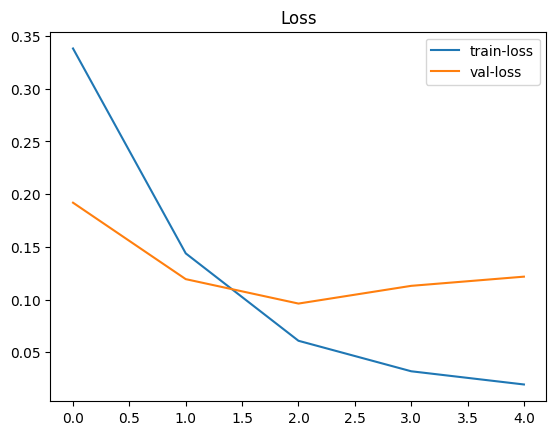

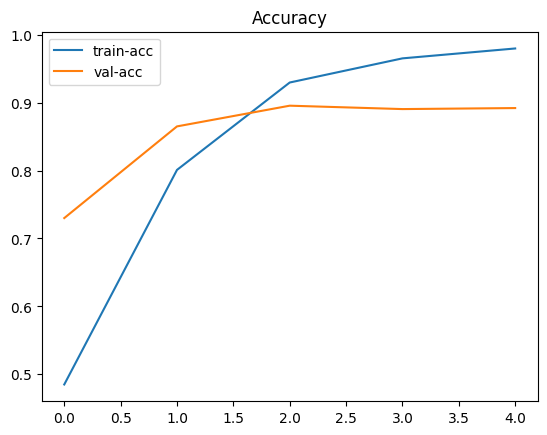

In [17]:
import matplotlib.pyplot as plt
plt.plot(history.history["loss"], label="train‑loss")
plt.plot(history.history["val_loss"], label="val‑loss")
plt.legend(); plt.title("Loss"); plt.show()

plt.plot(history.history["accuracy"], label="train‑acc")
plt.plot(history.history["val_accuracy"], label="val‑acc")
plt.legend(); plt.title("Accuracy"); plt.show()





lstm

In [18]:
LSTM_CELL_SIZE = 100
DROPOUT_RATE = 0.2


In [19]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

earlystop = EarlyStopping(patience = 5)
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_loss',patience = 2, factor = 0.8, min_lr = 0.00001)

callbacks = [earlystop, learning_rate_reduction]

In [20]:
lstm = Sequential()
lstm.add(LSTM(LSTM_CELL_SIZE, input_shape=(100,1))) # timewindow and column count for (X)
lstm.add(Dropout(DROPOUT_RATE))
lstm.add(Dense(1))
lstm.compile(loss='mean_squared_error', optimizer='adam')
lstm.summary()

d:\SRH\Emotion Detection Text\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100)            │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,901 (159.77 KB)

 Trainable params: 40,901 (159.77 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
lstm_history = lstm.fit(x=X_train,y=y_train, batch_size=64, validation_data=(X_val,y_val), epochs=5, verbose=1, shuffle=False, callbacks=callbacks)


Epoch 1/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 17s 53ms/step - loss: 0.1490 - val_loss: 0.1392 - learning_rate: 0.0010
Epoch 2/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 13s 52ms/step - loss: 0.1403 - val_loss: 0.1390 - learning_rate: 0.0010
Epoch 3/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step - loss: 0.1396 - val_loss: 0.1389 - learning_rate: 0.0010
Epoch 4/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - loss: 0.1392 - val_loss: 0.1389 - learning_rate: 0.0010
Epoch 5/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - loss: 0.1391 - val_loss: 0.1389 - learning_rate: 0.0010


# LMU

In [22]:
from sentence_transformers import SentenceTransformer

# Load a pretrained model
embedder = SentenceTransformer('all-MiniLM-L6-v2')  # fast and accurate

# Example input
sentences = ["I feel happy today", "This is frustrating"]

# Generate embeddings (output shape: [num_sentences, embedding_dim])
sentence_embeddings = embedder.encode(sentences)


In [26]:
from lmu import LMU
import torch.nn as nn

class LMUClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, memory_dim, output_dim):
        super().__init__()
        self.lmu = LMU(input_size=input_dim, hidden_size=hidden_dim, memory_size=memory_dim)
        self.fc1 = nn.Linear(hidden_dim, 128)
        self.relu = nn.ReLU()
        self.output = nn.Linear(128, output_dim)

    def forward(self, x):
        x, _ = self.lmu(x)  # LMU returns (output, state)
        out = self.relu(self.fc1(x))
        return self.output(out)


'lmu' is a metapackage that should not be imported directly. You might be intending to `import keras_lmu` (which used to be generically referred to as 'lmu'). For now this will have the effect of importing 'keras_lmu', but this will not work in the future so you should update your imports.


In [ ]:
model = LMUClassifier(input_dim= EMBED_SIZE,
                      hidden_dim=64,
                      memory_dim=32,
                      output_dim=6)

criterion = nn.CrossEntropyLoss()  # or nn.BCEWithLogitsLoss() for binary
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Example training loop
for epoch in range(10):
    model.train()
    for batch_x, batch_y in train_loader:
        preds = model(batch_x)
        loss = criterion(preds, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}, Loss: {loss.item():.4f}")


TypeError: LMU.__init__() missing 4 required positional arguments: 'memory_d', 'order', 'theta', and 'hidden_cell'

In [ ]:
import torch
import torch.nn as nn
from lmu import LMU

class LMUClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, memory_dim, output_dim):
        super(LMUClassifier, self).__init__()

        self.lmu = LMU(
            input_size=input_dim,
            hidden_size=hidden_dim,
            memory_size=memory_dim,
            memory_d=memory_dim,        # commonly set to memory_size
            order=256,                  # hyperparameter — controls memory depth
            theta=100.0,                # controls time scale (experiment with this)
            hidden_cell='gru'           # use 'rnn', 'lstm', or 'gru'
        )

        self.fc1 = nn.Linear(hidden_dim, 128)
        self.relu = nn.ReLU()
        self.output = nn.Linear(128, output_dim)

    def forward(self, x):
        """
        x shape: [batch_size, seq_len, input_dim]
        """
        out, _ = self.lmu(x)
        out = self.relu(self.fc1(out[:, -1, :]))  # last time step
        return self.output(out)


In [29]:
model = LMUClassifier(input_dim= EMBED_SIZE,
                      hidden_dim=64,
                      memory_dim=32,
                      output_dim=6)

criterion = nn.CrossEntropyLoss()  # or nn.BCEWithLogitsLoss() for binary
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Example training loop
for epoch in range(10):
    model.train()
    for batch_x, batch_y in train_loader:
        preds = model(batch_x)
        loss = criterion(preds, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}, Loss: {loss.item():.4f}")


ValueError: Unrecognized keyword arguments passed to LMU: {'input_size': 128, 'hidden_size': 64, 'memory_size': 32}